In [27]:
"""
import sys
!{sys.executable} -m pip install --user torchtext==0.8
"""

ERROR: Could not find a version that satisfies the requirement torchtext==0.8
ERROR: No matching distribution found for torchtext==0.8


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from nltk.tokenize import word_tokenize

import random

import re
import nltk

from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder



from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [98]:
df = pd.read_json("intents.json")



In [99]:
df_input = df.copy(deep= True)
df_input = pd.DataFrame(df_input['intents'].tolist(), index = df_input.index)
df_input.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [86]:
df = pd.DataFrame(df['intents'].tolist(), index = df.index)

In [87]:
df.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [88]:
df = df.explode('patterns').explode('responses')

In [89]:
df.head()

,tag,patterns,responses
0,greeting,Hi,Hello there. Tell me how are you feeling today?
0,greeting,Hi,Hi there. What brings you here today?
0,greeting,Hi,Hi there. How are you feeling today?
0,greeting,Hi,Great to see you. How do you feel currently?
0,greeting,Hi,Hello there. Glad to see you're back. What's g...


Unique Values and Counts in 'tag' column:
casual      66
greeting    60
about       48
default     40
sad         32
            ..
fact-28      1
fact-23      1
fact-16      1
fact-14      1
fact-24      1
Name: tag, Length: 80, dtype: int64


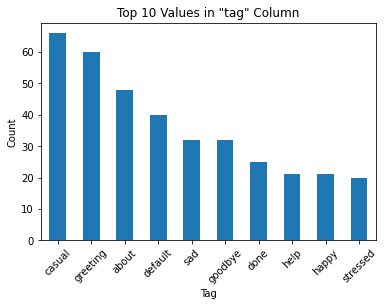

In [90]:
unique_tags = df['tag'].unique()
unique_tag_counts = df['tag'].value_counts()
print("Unique Values and Counts in 'tag' column:")
print(unique_tag_counts)

# Plot a bar chart with a limited number of displayed values
top_n = 10  # You can adjust this number based on your preference
unique_tag_counts.head(top_n).plot(kind='bar', rot=45)  # Rotating x-axis labels for better readability
plt.title(f'Top {top_n} Values in "tag" Column')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

In [91]:
df

,tag,patterns,responses
0,greeting,Hi,Hello there. Tell me how are you feeling today?
0,greeting,Hi,Hi there. What brings you here today?
0,greeting,Hi,Hi there. How are you feeling today?
0,greeting,Hi,Great to see you. How do you feel currently?
0,greeting,Hi,Hello there. Glad to see you're back. What's g...
...,...,...,...
76,fact-29,How do I know if I'm unwell?,"If your beliefs , thoughts , feelings or behav..."
77,fact-30,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
78,fact-31,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...
79,fact-32,What's the difference between sadness and depr...,"Sadness is a normal reaction to a loss, disapp..."


In [92]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


max_seq_length = 30

# Tokenize patterns
tokenizer_patterns = Tokenizer()
tokenizer_patterns.fit_on_texts(df['patterns'])
patterns_seq = tokenizer_patterns.texts_to_sequences(df['patterns'])
patterns_seq_padded = pad_sequences(patterns_seq, maxlen=max_seq_length, padding='post')

# Tokenize responses
tokenizer_responses = Tokenizer()
tokenizer_responses.fit_on_texts(df['responses'])
responses_seq = tokenizer_responses.texts_to_sequences(df['responses'])
responses_seq_padded = pad_sequences(responses_seq, maxlen=max_seq_length, padding='post')

# Split the data into training and testing sets
X_train_patterns, X_test_patterns, y_train, y_test = train_test_split(patterns_seq_padded, df['tag'], test_size=0.2, random_state=42)
X_train_responses, X_test_responses = train_test_split(responses_seq_padded, test_size=0.2, random_state=42)

# Create Intent Prediction Model
intent_input = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=len(tokenizer_patterns.word_index) + 1, output_dim=50)(intent_input)
bidirectional_lstm = Bidirectional(LSTM(64))(embedding_layer)
intent_output = Dense(units=len(set(df['tag'])), activation='softmax')(bidirectional_lstm)

intent_model = Model(inputs=intent_input, outputs=intent_output)
intent_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert y_train to numerical labels
label_encoder = LabelEncoder()
y_train_numerical_intent = label_encoder.fit_transform(y_train)

# One-hot encode y_train for intent model
intent_labels_train = to_categorical(y_train_numerical_intent, num_classes=len(set(df['tag'])))

# Reshape intent labels to match the model output shape
intent_labels_train = intent_labels_train.reshape(intent_labels_train.shape[0], intent_labels_train.shape[1])

# Fit the intent model
history_intent = intent_model.fit(X_train_patterns, intent_labels_train, epochs=10, batch_size=1, validation_split=0.2)

# Create Response Generation Model
response_input = Input(shape=(max_seq_length,))
response_embedding_layer = Embedding(input_dim=len(tokenizer_responses.word_index) + 1, output_dim=50)(response_input)
bidirectional_lstm_response = Bidirectional(LSTM(64, return_sequences=True))(response_embedding_layer)
response_output = Dense(len(tokenizer_responses.word_index) + 1, activation='softmax')(bidirectional_lstm_response)

response_model = Model(inputs=response_input, outputs=response_output)
response_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert y_train to numerical labels
y_train_numerical_response = label_encoder.transform(y_train)

# One-hot encode y_train for response model
response_labels_train = to_categorical(responses_seq_padded, num_classes=len(tokenizer_responses.word_index) + 1)

# Remove the reshaping of response labels
# response_labels_train = response_labels_train.reshape(response_labels_train.shape[0], response_labels_train.shape[1], 1)

print(X_train_responses.shape)
print(response_labels_train.shape)


# Fit the response model
history_response = response_model.fit(X_train_responses, response_labels_train, epochs=10, batch_size=1, validation_split=0.2)



Epoch 1/10
422/422 [==============================] - 19s 32ms/step - loss: 3.7448 - accuracy: 0.1185 - val_loss: 3.3592 - val_accuracy: 0.1415
Epoch 2/10
422/422 [==============================] - 12s 28ms/step - loss: 2.9053 - accuracy: 0.2607 - val_loss: 2.8657 - val_accuracy: 0.2925
Epoch 3/10
422/422 [==============================] - 8s 19ms/step - loss: 2.2765 - accuracy: 0.3981 - val_loss: 2.3808 - val_accuracy: 0.4717
Epoch 4/10
422/422 [==============================] - 8s 19ms/step - loss: 1.7264 - accuracy: 0.5829 - val_loss: 1.9674 - val_accuracy: 0.6038
Epoch 5/10
422/422 [==============================] - 7s 18ms/step - loss: 1.2690 - accuracy: 0.7085 - val_loss: 1.6484 - val_accuracy: 0.6509
Epoch 6/10
422/422 [==============================] - 7s 17ms/step - loss: 0.9630 - accuracy: 0.7962 - val_loss: 1.4760 - val_accuracy: 0.7264
Epoch 7/10
422/422 [==============================] - 8s 20ms/step - loss: 0.7540 - accuracy: 0.8294 - val_loss: 1.3431 - val_accuracy: 0.80

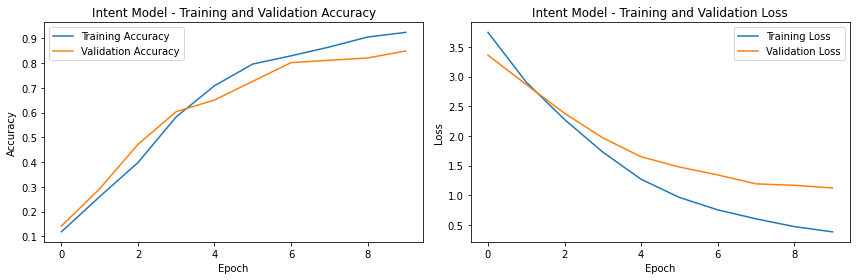

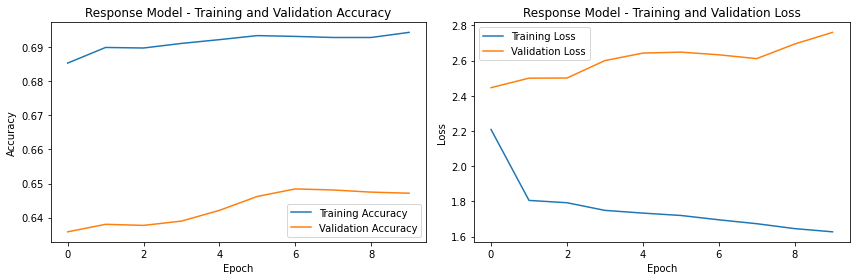

In [93]:
import matplotlib.pyplot as plt

# Plotting Accuracy and Loss for Intent Model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_intent.history['accuracy'], label='Training Accuracy')
plt.plot(history_intent.history['val_accuracy'], label='Validation Accuracy')
plt.title('Intent Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_intent.history['loss'], label='Training Loss')
plt.plot(history_intent.history['val_loss'], label='Validation Loss')
plt.title('Intent Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting Accuracy and Loss for Response Model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_response.history['accuracy'], label='Training Accuracy')
plt.plot(history_response.history['val_accuracy'], label='Validation Accuracy')
plt.title('Response Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_response.history['loss'], label='Training Loss')
plt.plot(history_response.history['val_loss'], label='Validation Loss')
plt.title('Response Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [102]:
def get_random_response(tag):
    tag 
    tag_data = df_input[df_input['tag'] == tag]
    if not tag_data.empty:
        responses_list = tag_data['responses'].iloc[0]
        return random.choice(responses_list)
    else:
        return "Tag not found"

while True:
    # Tokenize a new sentence for intent prediction
    new_sentence = str(input())
    if new_sentence == "exit":
        break;
    new_sentence_seq = tokenizer_patterns.texts_to_sequences([new_sentence])
    new_sentence_padded = pad_sequences(new_sentence_seq, maxlen=max_seq_length, padding='post')

    # Predict the intent
    intent_prediction = intent_model.predict(new_sentence_padded)
    predicted_intent_index = np.argmax(intent_prediction)
    predicted_intent = label_encoder.classes_[predicted_intent_index]
    print(f"Predicted Intent: {predicted_intent}")

    # Tokenize the new sentence for response generation
    new_response_input = tokenizer_responses.texts_to_sequences([new_sentence])
    new_response_input_padded = pad_sequences(new_response_input, maxlen=max_seq_length, padding='post')

    # Predict the response
    #response_prediction = response_model.predict(new_response_input_padded)
    #predicted_response_index = np.argmax(response_prediction, axis=-1)
    #predicted_response = " ".join([tokenizer_responses.index_word[i] for i in predicted_response_index[0] if i != 0])


    
    predicted_response = get_random_response(predicted_intent)
    
    print(f"Predicted Response: {predicted_response}")
    

hello
1/1 [==============================] - 0s 36ms/step
Predicted Intent: greeting
Predicted Response: Hi there. How are you feeling today?
i feel like dying
1/1 [==============================] - 0s 28ms/step
Predicted Intent: sad
Predicted Response: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?


KeyboardInterrupt: Interrupted by user